In [1]:
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps

In [3]:
conn = ps.connect(dbname="northhwind",
                  user="postgres",
                  password="07062009",
                  port = "5432")

In [5]:
pip install psycopg2

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
    --------------------------------------- 0.0/1.2 MB 330.3 kB/s eta 0:00:04
   - -------------------------------------- 0.0/1.2 MB 487.6 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.2 MB 819.2 kB/s eta 0:00:02
   ------- -------------------------------- 0.2/1.2 MB 1.1 MB/s eta 0:00:01
   ------------- -------------------------- 0.4/1.2 MB 1.6 MB/s eta 0:00:01
   --------------------- ------------------ 0.6/1.2 MB 2.3 MB/s eta 0:00:01
   ------------------------------- -------- 0.9/1.2 MB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## <p style="background-color:lightblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 30px 60px;">**ÜRÜN FİYAT ANALİZİ CASE 1**</p>

In [4]:
sql = """WITH p_price AS (
        SELECT product_name,
               unit_price,
               CASE WHEN unit_price < 10                  THEN '0-10'
                    WHEN unit_price >= 10 AND unit_price < 20  THEN '10-20'
                    WHEN unit_price >= 20 AND unit_price < 30  THEN '20-30'
                    WHEN unit_price >= 30 AND unit_price < 40  THEN '30-40'
                    WHEN unit_price >= 40 AND unit_price < 50  THEN '40-50'
                    WHEN unit_price >= 50 AND unit_price < 60  THEN '50-60'
                    WHEN unit_price >= 60 AND unit_price < 70  THEN '60-70'
                    WHEN unit_price >= 70 AND unit_price < 80  THEN '70-80'
                    WHEN unit_price >= 80 AND unit_price < 90  THEN '80-90'
                    WHEN unit_price >= 90 AND unit_price < 100 THEN '90-100'
                    WHEN unit_price >= 100                THEN '100+'
                     END AS price_segment
          FROM products
       ) 
  SELECT 
       product_name,
       unit_price,
       price_segment,
       count(product_name) OVER (PARTITION BY price_segment) AS segment_product_count
  FROM p_price """

In [5]:
df = sqlio.read_sql_query(sql,conn)
df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_8288\1600180838.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql,conn)


,product_name,unit_price,price_segment,segment_product_count
0,Tunnbröd,9.00,0-10,11
1,Konbu,6.00,0-10,11
2,Teatime Chocolate Biscuits,9.20,0-10,11
3,Rhönbräu Klosterbier,7.75,0-10,11
4,Tourtière,7.45,0-10,11


In [6]:
df.shape

(77, 4)

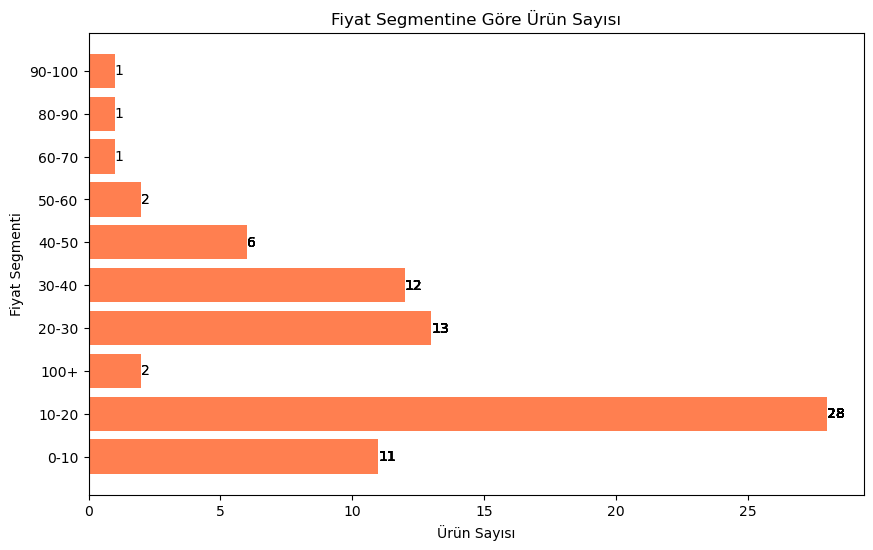

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(df['price_segment'], df['segment_product_count'], color='coral')
plt.ylabel('Fiyat Segmenti')
plt.xlabel('Ürün Sayısı')
plt.title('Fiyat Segmentine Göre Ürün Sayısı')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(int(bar.get_width())),
             va='center', ha='left', fontsize=10)

plt.show()




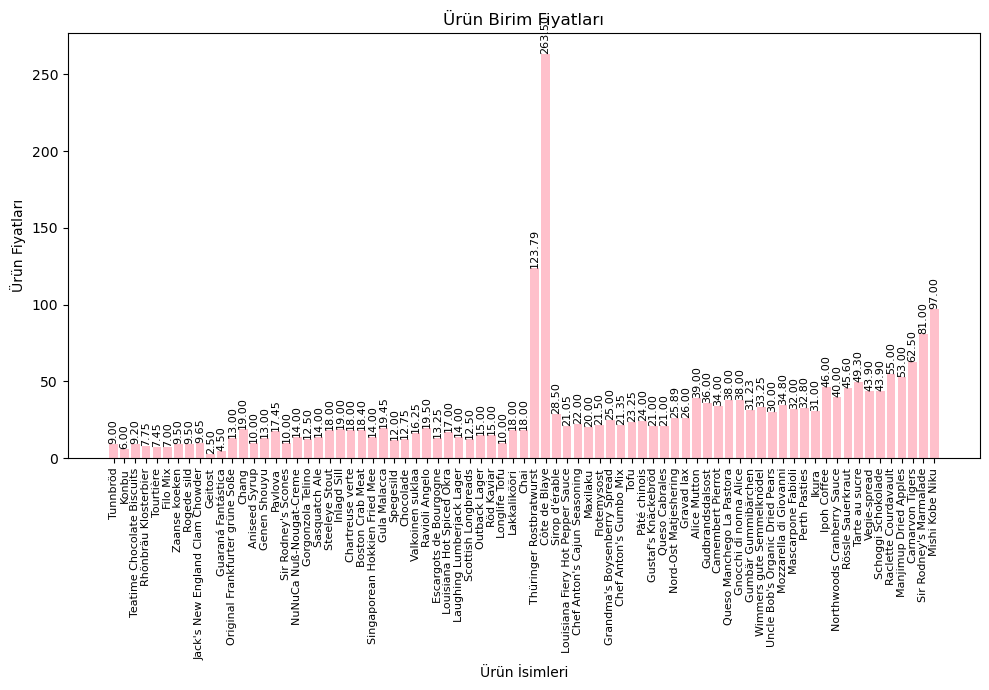

In [8]:
plt.figure(figsize=(10, 7))
bars = plt.bar(df['product_name'], df['unit_price'], color='pink')
plt.xlabel('Ürün İsimleri')
plt.ylabel('Ürün Fiyatları')
plt.title('Ürün Birim Fiyatları')
plt.xticks(rotation=90, fontsize=8)  # 90 derece döndür ve yazı fontunu küçült

# Çubukların üzerine ürün fiyatlarını ekleyelim
for bar, price in zip(bars, df['unit_price']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{price:.2f}', 
             ha='center', va='bottom', fontsize=8, rotation=90, color='black')

plt.tight_layout()  # Grafik öğelerinin sığmasını sağlar
plt.show()

## <p style="background-color:lightblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 30px 60px;">**ÜRÜN FİYAT ANALİZİ CASE 2**</p>

In [9]:
sql2 = """WITH cte_price AS (
SELECT
d.product_id,
	p.product_name,
	ROUND(LEAD(d.unit_price) OVER (PARTITION BY p.product_name ORDER BY o.order_date)::NUMERIC,2) AS current_price,
	ROUND(LAG(d.unit_price) OVER (PARTITION BY p.product_name ORDER BY o.order_date)::NUMERIC,2) AS previous_unit_price
FROM products AS p
INNER JOIN order_details AS d
ON p.product_id = d.product_id
INNER JOIN orders AS o
ON d.order_id = o.order_id
)
SELECT
	c.product_name,
	c.current_price,
	c.previous_unit_price,
	ROUND(100*(c.current_price - c.previous_unit_price)/c.previous_unit_price) AS percentage_increase
FROM cte_price AS c
WHERE c.current_price != c.previous_unit_price
GROUP BY 
	c.product_name,
	c.current_price,
	c.previous_unit_price """

In [10]:
df2 = sqlio.read_sql_query(sql2,conn)
df2.head()

C:\Users\User\AppData\Local\Temp\ipykernel_8288\229322232.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = sqlio.read_sql_query(sql2,conn)


,product_name,current_price,previous_unit_price,percentage_increase
0,Chef Anton's Gumbo Mix,21.35,17.0,26.0
1,Sasquatch Ale,14.00,11.2,25.0
2,Spegesild,12.00,9.6,25.0
3,Wimmers gute Semmelknödel,33.25,26.6,25.0
4,Carnarvon Tigers,62.50,50.0,25.0


In [11]:
df2.shape

(80, 4)

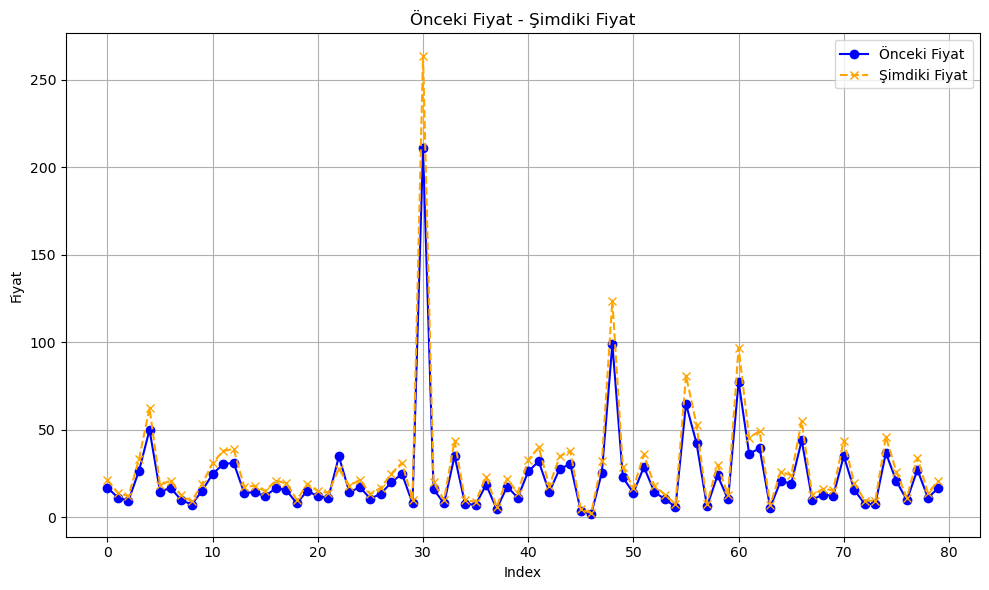

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df2['previous_unit_price'], label='Önceki Fiyat', marker='o', linestyle='-', color='blue')
plt.plot(df2['current_price'], label='Şimdiki Fiyat', marker='x', linestyle='--', color='orange')


plt.xlabel('Index')
plt.ylabel('Fiyat')
plt.title('Önceki Fiyat - Şimdiki Fiyat')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


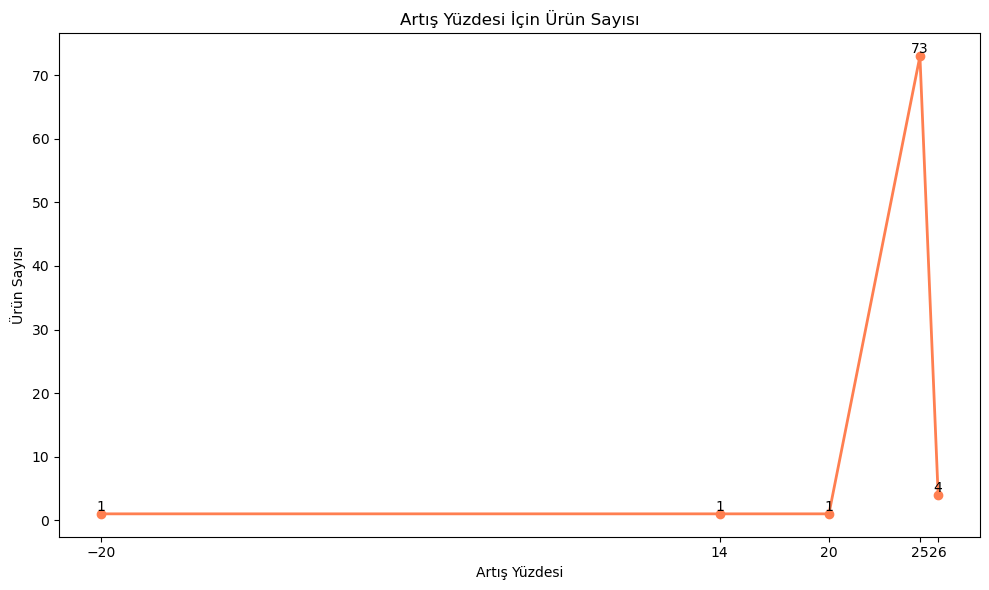

In [13]:
import matplotlib.pyplot as plt

# Her yüzdelik artış değeri için ürün sayılarını alıyoruz
product_counts = df2.groupby('percentage_increase')['product_name'].count()

# Line grafiği oluşturma
plt.figure(figsize=(10, 6))
plt.plot(product_counts.index, product_counts, marker='o', color='coral', linestyle='-', linewidth=2)

plt.title('Artış Yüzdesi İçin Ürün Sayısı')
plt.xlabel('Artış Yüzdesi')
plt.ylabel('Ürün Sayısı')
plt.xticks(product_counts.index)

plt.tight_layout()

# Noktaların üzerine ürün sayılarını eklemek için
for i, count in product_counts.items():
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


In [14]:
# Percentage increase değeri 25.00 olan ürünleri göstermek için datayı filtreliyoruz
selected_products = df2[df2['percentage_increase'] == 25.00]

# Seçilen ürünleri gösteren bir tablo oluşturuyoruz
selected_products_table = selected_products[['product_name', 'current_price', 'previous_unit_price']]

# Tabloyu görüntülüyoruz
print(selected_products_table)

                        product_name  current_price  previous_unit_price
1                      Sasquatch Ale          14.00                 11.2
2                          Spegesild          12.00                  9.6
3          Wimmers gute Semmelknödel          33.25                 26.6
4                   Carnarvon Tigers          62.50                 50.0
5                   Boston Crab Meat          18.40                 14.7
..                               ...            ...                  ...
74                       Ipoh Coffee          46.00                 36.8
75             Nord-Ost Matjeshering          25.89                 20.7
77                 Camembert Pierrot          34.00                 27.2
78           NuNuCa Nuß-Nougat-Creme          14.00                 11.2
79  Louisiana Fiery Hot Pepper Sauce          21.05                 16.8

[73 rows x 3 columns]


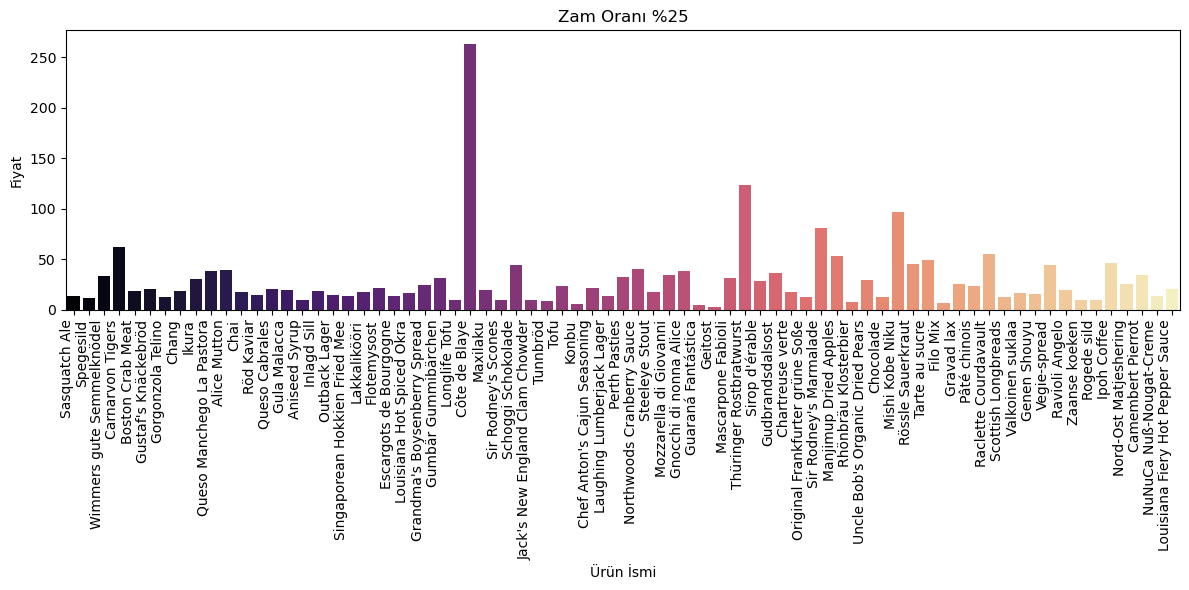

In [15]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=selected_products, x='product_name', y='current_price', palette='magma') 
plt.title('Zam Oranı %25')
plt.xlabel('Ürün İsmi')
plt.ylabel('Fiyat')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

plt.show()

In [85]:
# Percentage increase değeri 25.00 olan ürünleri göstermek için datayı filtreliyoruz
non_profitable_products = df2[df2['percentage_increase'] < 25.00]

# Seçilen ürünleri gösteren bir tablo oluşturuyoruz
non_profitable_products_table = non_profitable_products[['product_name', 'current_price', 'previous_unit_price']]

# Tabloyu görüntülüyoruz
print(non_profitable_products_table)

                     product_name  current_price  previous_unit_price
22         Mozzarella di Giovanni           27.8                 34.8
50                 Queso Cabrales           16.8                 14.0
76  Singaporean Hokkien Fried Mee           11.2                  9.8


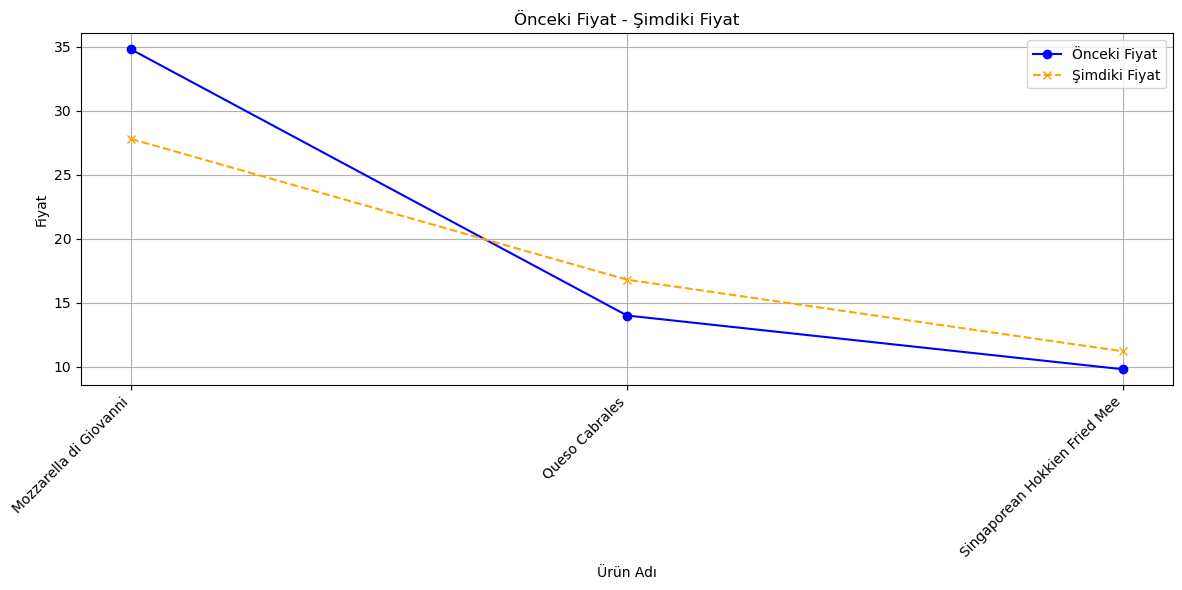

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# x ekseninde ürün adlarını göstermek için x değerlerini ayarlıyoruz
x_values = range(len(non_profitable_products))

# Çizgi grafikleri oluşturuyoruz
plt.plot(x_values, non_profitable_products['previous_unit_price'], label='Önceki Fiyat', marker='o', linestyle='-', color='blue')
plt.plot(x_values, non_profitable_products['current_price'], label='Şimdiki Fiyat', marker='x', linestyle='--', color='orange')

# Ürün adlarını x eksenine yerleştiriyoruz
plt.xticks(x_values, non_profitable_products['product_name'], rotation=45, ha='right')

plt.xlabel('Ürün Adı')
plt.ylabel('Fiyat')
plt.title('Önceki Fiyat - Şimdiki Fiyat')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
